## Introduction

https://www.kaggle.com/c/microsoft-malware-prediction/overview/description

This is the initial attempt of this malware prediction project. This notebook mainly focus on data cleaning and initial data exploration. Due to the lare data set, data cleaning has been broken down to sub-sets and preserved for future use. 

## Imports

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os.path
import time
import pickle
from sinfo import sinfo
import Util

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## I. Load Raw Data

In [2]:
DATA_PATH = 'Data/'
MODEL_PATH = 'Model/'

In [ ]:
df_pkl = DATA_PATH + "df_train_data.pkl"

if not os.path.exists(df_pkl):
    df_train_data = pd.read_csv(DATA_PATH + "train.csv")
    df_train_data.to_pickle(df_pkl)

df_train_data = pd.read_pickle(df_pkl)
display(df_train_data.head(10))


In [ ]:
# take a quick look of the data set
display(df_train_data.shape)
df_train_data.info()

# Is this an imbalance dataset?
unique_elements, counts_elements = np.unique(df_train_data['HasDetections'], return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

# No, this is a balanced dataset.(value: count) 0:4462591, 1:4458892

## II. Data Preprocessing

### II.I Drop columns contains too many NaN values

In [ ]:
# Get number of columns have NaN values
null_columns = df_train_data.columns[df_train_data.isnull().any()]
display("Original number of columns contains NaN values: {0}".format(len(null_columns)))

# get NaN count per each column
display(df_train_data[null_columns].isnull().sum())

Drop columns based on the following conditions:
* columns which have NaN values over 35% of the total rows. Because these columns can't provide too much value for later data analysis
* Since we don't have reference for these identifiers, they don't provide much information for us. Drop these identifier columns. 
* If a column contains too many unique values, almost as many as the total number of rows, this could also be an identifier column. Drop this column.
* Also, if a column contains only 1 unique value, this column won't provide meaningful information, drop this column.

In [ ]:
columns_to_drop = Util.get_columns_to_drop(df_train_data,null_columns,0.35)
display(columns_to_drop)

# drop columns for train data
df_train_data = df_train_data.drop(columns = columns_to_drop)

# check data frame again, no columns got dropped based on above conditions
df_train_data.shape

#if exported csv is not found,export this dataframe to csv
csv_file = DATA_PATH + "train_clean_1.csv"
if not os.path.exists(csv_file):
    df_train_data.to_csv(csv_file, index = False)

In [ ]:
# drop columns for test data. Export to csv
df_test_data = df_test_data.drop(columns = columns_to_drop)
df_test_data.shape
csv_file = DATA_PATH + "test_clean_1.csv"
if not os.path.exists(csv_file):
    df_test_data.to_csv(csv_file, index = False)

In [ ]:
# reload data from cleaned train csv
df_pkl = DATA_PATH + "df_train_data_clean.pkl"

if not os.path.exists(df_pkl):
    df_train_data_clean = pd.read_csv(DATA_PATH + "train_clean_1.csv")
    df_train_data_clean.to_pickle(df_pkl)

df_train_data_clean = pd.read_pickle(df_pkl)
display(df_train_data_clean.head(10))

In [ ]:
# check dataframe info
df_train_data_clean.shape
df_train_data_clean.info()

### II.II Categorize Data Types and fill in NaN values accordingly. Then preserve the results.

In [ ]:
# Categorize columns into numeric or string data types
columns_numeric = []
columns_str = []

for column in df_train_data_clean.columns:
    data = df_train_data_clean[column].values[0]
    
    if type(data) is str:
        columns_str.append(column)
    elif (type(data.item()) is int or type(data.item()) is float):
        columns_numeric.append(column)

# verify we are not missing any columns
assert len(columns_numeric) + len(columns_str) == len(df_train_data_clean.columns),"Total number of columns NOT matched."

In [ ]:
# create dataframes: numeric columns and string columns
# so it's easier to fill up NaN values later
df_train_clean_numeric = df_train_data_clean[columns_numeric]
df_train_clean_str = df_train_data_clean[columns_str]

# get NaN count per each column
display(df_train_clean_numeric.isnull().sum())
display(df_train_clean_numeric.head())

display(df_train_clean_str.isnull().sum())
display(df_train_clean_str.head())

Notes: for categorical data, fill NaN with mode, for numeric, fill in with median/average

* categorical data, numeric values

In [ ]:
# categorical data, numeric values, use mode()
columns_mode = ['RtpStateBitfield',
                'AVProductsInstalled',
                'AVProductsEnabled',
                'UacLuaenable']

# check unique values per each column
dic_unique_vals_mode = Util.getUniqueValuesPerColumn(df_train_clean_numeric,columns_mode)

display(dic_unique_vals_mode)

result = Util.fillInNaN(df_train_clean_numeric,columns_mode,'mode')

* Non-categorical numeric values

In [ ]:
# Non-categorical numeric values, use median(), this is less sensitive to outliers
columns_median = ['Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_ProcessorCoreCount',
                 'Census_InternalBatteryNumberOfCharges',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM']

dic_unique_vals_median = Util.getUniqueValuesPerColumn(df_train_clean_numeric,columns_median)
display(dic_unique_vals_median)

result = result & Util.fillInNaN(df_train_clean_numeric,columns_median,'median')

* boolean columns

In [ ]:
# columns contains boolean values considered as categorical, fill NaN with mode()
columns_bool = ['IsProtected',
                'SMode',
                'Firewall',
                'Census_HasOpticalDiskDrive',
                'Census_IsFlightsDisabled',
                'Census_IsVirtualDevice',
                'Census_IsAlwaysOnAlwaysConnectedCapable']

dic_unique_vals_bool = Util.getUniqueValuesPerColumn(df_train_clean_numeric,columns_bool)
display(dic_unique_vals_bool)

result = result & Util.fillInNaN(df_train_clean_numeric,columns_bool,'mode')

* Identifier Columns

In [ ]:
# get identifier columns
identifier_columns = []

for column in df_train_clean_numeric.columns:
    if 'identifier' in column.lower():
        identifier_columns.append(column)

display("Number of identifier columns:{0}".format(len(identifier_columns)))
display(identifier_columns)

In [ ]:
# fill NaN value with empty string for identifier columns
columns_identifier = []

for column in df_train_clean_numeric.columns:
    if 'identifier' in column.lower():
        columns_identifier.append(column)

dic_unique_vals_identifier = Util.getUniqueValuesPerColumn(df_train_clean_numeric,columns_identifier)

result = result & Util.fillInNaN(df_train_clean_numeric,columns_identifier,'')

In [ ]:
# verify all the identifier columns contains no NaN values
display(df_train_clean_numeric[columns_identifier].isnull().sum())

display(df_train_clean_numeric.isnull().sum())

In [ ]:
# drop identifier columns to get the minimum workable version of data
df_train_clean_numeric = df_train_clean_numeric.drop(columns = identifier_columns)

In [ ]:
#verify df_train_clean_numeric contains NO NaN value after fill up NaN values
if result:
    display(df_train_clean_numeric.isnull().sum())
else:
    display("Failed to fill NaN")

In [ ]:
display(df_train_clean_numeric.head())

# export to csv first
csv_file = DATA_PATH + "train_clean_numeric.csv"
if not os.path.exists(csv_file):
    df_train_clean_numeric.to_csv(csv_file, index = False)  

* string value columns:
* Fill in NaN values with empty string. 
* Take out first column 'MachineIdentifier' from exisitng dataframe, and preserve that as a seperate dataframe for later use. (This column will be merged with other dataframes based on idex.
* Drop columns contains 'version' in column names. This column should be treated differently. Save them as seperate dataframe.
* Finally, export cleaned string value dataframe to csv file and pickle it.

In [ ]:
# fill up NaN values with empty string for string value columns. (or categorize it as NA category)
# use empty string to fill up NaN in the following case
columns_str = ['OsBuildLab','Census_PrimaryDiskTypeName','Census_ChassisTypeName','Census_PowerPlatformRoleName']

result = result & Util.fillInNaN(df_train_clean_str,columns_str,'')

In [ ]:
# verify there's no NaN values
if result:
    display(df_train_clean_str.isnull().sum())
else:
    display("Failed to fill NaN")

In [ ]:
df_train_clean_str.head()

In [ ]:
# Get first column: MachineIdentifier and preserve the dataframe
df_train_MachineIdentifier = pd.DataFrame(df_train_clean_str['MachineIdentifier'])

df_pkl = DATA_PATH + "df_train_MachineIdentifier.pkl"

# save dataframe
if not os.path.exists(df_pkl):
    df_train_MachineIdentifier.to_pickle(df_pkl)


In [ ]:
# drop 'MachineIdentifier' column from the dataframe. 
# We want to have a data frame contains string values without MachineIdentifier column.
df_train_clean_str = df_train_clean_str.drop(columns = 'MachineIdentifier')
df_train_clean_str.head()

In [ ]:
# exclude out columns contain 'version', this will be processed differently later
# save the dataframe

columns_version = []

for column in df_train_clean_str.columns:
    if 'version' in column.lower():
        columns_version.append(column)

df_train_version = pd.DataFrame(df_train_clean_str[columns_version])

df_pkl = DATA_PATH + "df_train_version.pkl"

# save dataframe
if not os.path.exists(df_pkl):
    df_train_version.to_pickle(df_pkl)

In [ ]:
# drop 'version' column
df_train_clean_str = df_train_clean_str.drop(columns = columns_version)
df_train_clean_str.head()

In [ ]:
# str columns, export to csv first
csv_file = DATA_PATH + "train_clean_str.csv"

if not os.path.exists(csv_file):
    df_train_clean_str.to_csv(csv_file, index = False)

In [ ]:
#str columns, reload data from csv, and save the dataframe
df_pkl = DATA_PATH + "df_train_clean_str.pkl"

if not os.path.exists(df_pkl):
    # re-load from exported csv
    df_train_clean_str = pd.read_csv(DATA_PATH + "train_clean_str.csv")
    df_train_clean_str.to_pickle(df_pkl)

df_train_clean_str = pd.read_pickle(df_pkl)
display(df_train_clean_str.head(10))

Make the string value dataframes as dummies dataframe and preserve it. This will be used later on for feature engineering. Another option is to save it as sparse matrix.

In [ ]:
# save str dummies dataframe
df_pkl = DATA_PATH + "df_train_clean_str_dummies.pkl"

if not os.path.exists(df_pkl):
    df_train_clean_str_dummies = pd.get_dummies(df_train_clean_str)
    df_train_clean_str_dummies.to_pickle(df_pkl)

df_train_clean_str_dummies = pd.read_pickle(df_pkl)
display(df_train_clean_str_dummies.head(10))

## III. Prototyping - Logistic Regression
### Numeric columns only

In [3]:
df_pkl = DATA_PATH + "train_clean_numeric.pkl"

if not os.path.exists(df_pkl):
    # re-load from exported csv
    df_train_clean_numeric = pd.read_csv(DATA_PATH + "train_clean_numeric.csv")
    df_train_clean_numeric.to_pickle(df_pkl)

df_train_clean_numeric = pd.read_pickle(df_pkl)
display(df_train_clean_numeric.head(10))

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,OsBuild,OsSuite,IsProtected,AutoSampleOptIn,...,Census_OSBuildRevision,Census_IsPortableOperatingSystem,Census_IsFlightsDisabled,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,HasDetections
0,0,7.0,0,1.0,1.0,1,17134,256,1.0,0,...,165,0,0.0,0,0.0,0,0,0.0,0.0,0
1,0,7.0,0,1.0,1.0,1,17134,256,1.0,0,...,1,0,0.0,0,0.0,0,0,0.0,0.0,0
2,0,7.0,0,1.0,1.0,1,17134,768,1.0,0,...,165,0,0.0,0,0.0,0,0,0.0,0.0,0
3,0,7.0,0,1.0,1.0,1,17134,256,1.0,0,...,228,0,0.0,0,0.0,0,0,0.0,0.0,1
4,0,7.0,0,1.0,1.0,1,17134,768,1.0,0,...,191,0,0.0,0,0.0,0,0,0.0,0.0,1
5,0,7.0,0,1.0,1.0,1,17134,256,1.0,0,...,165,0,0.0,0,0.0,0,0,0.0,0.0,1
6,0,7.0,0,2.0,1.0,1,17134,768,1.0,0,...,165,0,0.0,1,0.0,0,0,0.0,0.0,1
7,0,7.0,0,1.0,1.0,1,14393,768,1.0,0,...,0,0,0.0,0,0.0,0,0,0.0,0.0,0
8,0,7.0,0,1.0,1.0,1,17134,256,1.0,0,...,254,0,0.0,0,0.0,0,0,0.0,0.0,0
9,0,7.0,0,2.0,1.0,1,16299,768,1.0,0,...,431,0,0.0,1,0.0,0,0,0.0,1.0,1


'Train Test Split: X shape:(8921483, 32), y shape:(8921483, 1), 1.9603450298309326 sec.'

C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


'Finish scaling. 18.023760080337524 sec.'

'Predict model accuracy:0.5872889995331495'

array([[ 870835,  914202],
       [ 558596, 1224961]], dtype=int64)

              precision    recall  f1-score   support

           0       0.61      0.49      0.54   1785037
           1       0.57      0.69      0.62   1783557

   micro avg       0.59      0.59      0.59   3568594
   macro avg       0.59      0.59      0.58   3568594
weighted avg       0.59      0.59      0.58   3568594



'Compute ROC curve and AUC:0.6156749613973811,2.8733017444610596 sec.'

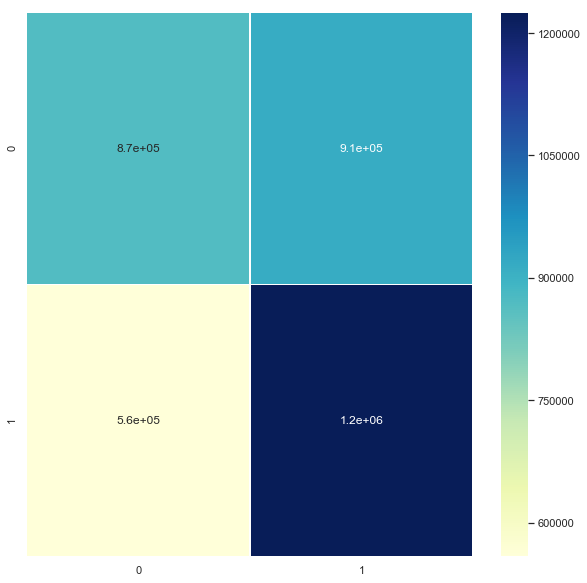

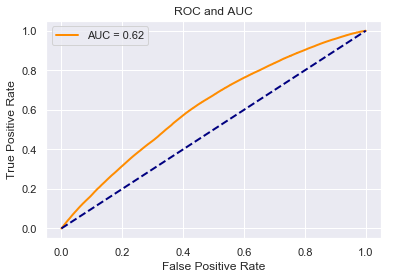

AUC score: 0.616


0.6156749613973811

In [4]:
# perform logistic regression with df_train_clean_numeric, StandardScaler()
train_test_list = Util.trainTestSplit(df_train_clean_numeric,'HasDetections',0.4)

# use StandardScaler
scaler = StandardScaler()
train_test_list = Util.scale(train_test_list,scaler)

# use Logistic Regression
save_model = MODEL_PATH + 'logreg_model_1.sav'
logreg_model = LogisticRegression(solver = "lbfgs", multi_class = "auto")

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, logreg_model, save_model)
    
Util.predictModel(train_test_list, save_model)
# ROC, AUC
Util.plotROC(train_test_list, save_model)

'Train Test Split: X shape:(8921483, 32), y shape:(8921483, 1), 15.56027340888977 sec.'

C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


'Finish scaling. 9.763212442398071 sec.'

'Predict model accuracy:0.5392493514252392'

array([[ 256474, 1528563],
       [ 115669, 1667888]], dtype=int64)

              precision    recall  f1-score   support

           0       0.69      0.14      0.24   1785037
           1       0.52      0.94      0.67   1783557

   micro avg       0.54      0.54      0.54   3568594
   macro avg       0.61      0.54      0.45   3568594
weighted avg       0.61      0.54      0.45   3568594



'Compute ROC curve and AUC:0.6143884080598212,2.7633860111236572 sec.'

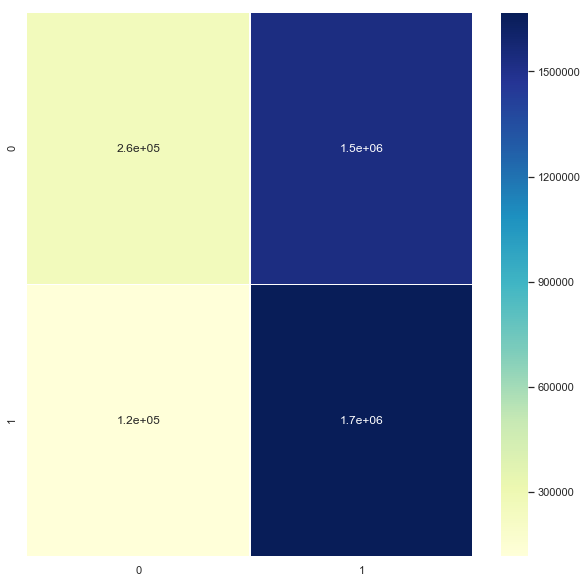

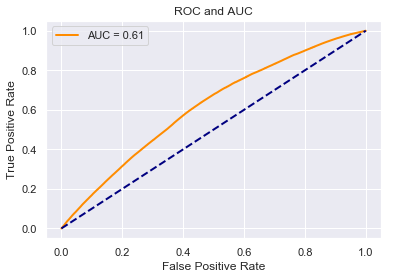

AUC score: 0.614


0.6143884080598212

In [5]:
# perform logistic regression with df_train_clean_numeric, MinMaxScaler()
train_test_list = Util.trainTestSplit(df_train_clean_numeric,'HasDetections',0.4)

# use MinMaxScaler
scaler = MinMaxScaler()
train_test_list = Util.scale(train_test_list,scaler)

# use Logistic Regression
save_model = MODEL_PATH + 'logreg_model_2.sav'
logreg_model = LogisticRegression(solver = "lbfgs", multi_class = "auto")

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, logreg_model, save_model)
    
Util.predictModel(train_test_list, save_model)
# ROC, AUC
Util.plotROC(train_test_list, save_model)

* Comparing StandardScaler vs MinMaxScaler, StandardScaler gives high AUC scores. So, StandardScaler will be used for later.

##  IV. Advanced Model - Random Forest

### Numeric columns only

In [6]:
# perform Random Forest df_train_clean_numeric
train_test_list = Util.trainTestSplit(df_train_clean_numeric,'HasDetections',0.4)

# use StandardScaler
scaler = StandardScaler()
train_test_list = Util.scale(train_test_list,scaler)

'Train Test Split: X shape:(8921483, 32), y shape:(8921483, 1), 11.565800428390503 sec.'

C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\cheny\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


'Finish scaling. 17.67121934890747 sec.'

'Predict model accuracy:0.5515130048416828'

array([[1282484,  502553],
       [1097915,  685642]], dtype=int64)

              precision    recall  f1-score   support

           0       0.54      0.72      0.62   1785037
           1       0.58      0.38      0.46   1783557

   micro avg       0.55      0.55      0.55   3568594
   macro avg       0.56      0.55      0.54   3568594
weighted avg       0.56      0.55      0.54   3568594



'Compute ROC curve and AUC:0.5811994016912603,45.814571142196655 sec.'

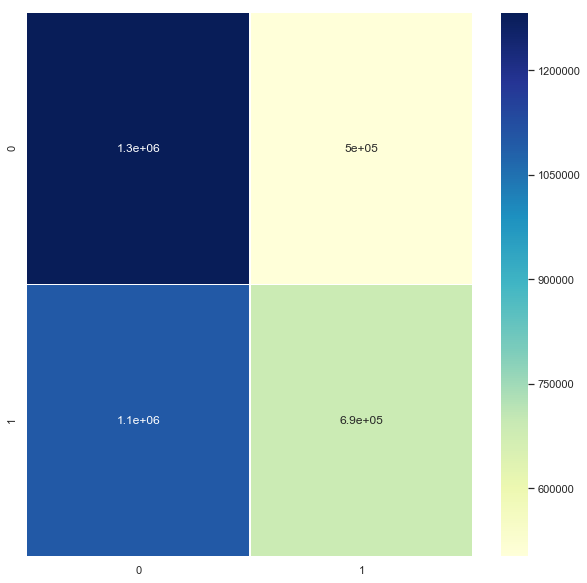

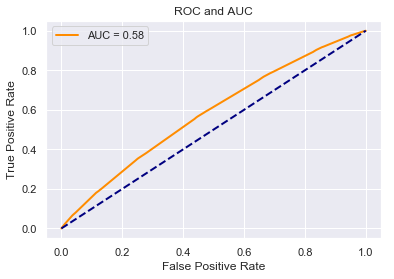

AUC score: 0.581


In [7]:
# random forest, n_estimators = 10
save_model =  MODEL_PATH + 'random_forest_model_10.sav'
random_forest_classifier = RandomForestClassifier()

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, random_forest_classifier, save_model)
    
Util.predictModel(train_test_list, save_model)
# ROC, AUC
auc = Util.plotROC(train_test_list, save_model)

'Predict model accuracy:0.6038820891365059'

array([[1254657,  530380],
       [ 883204,  900353]], dtype=int64)

              precision    recall  f1-score   support

           0       0.59      0.70      0.64   1785037
           1       0.63      0.50      0.56   1783557

   micro avg       0.60      0.60      0.60   3568594
   macro avg       0.61      0.60      0.60   3568594
weighted avg       0.61      0.60      0.60   3568594



'Compute ROC curve and AUC:0.6514413749957542,54.261455059051514 sec.'

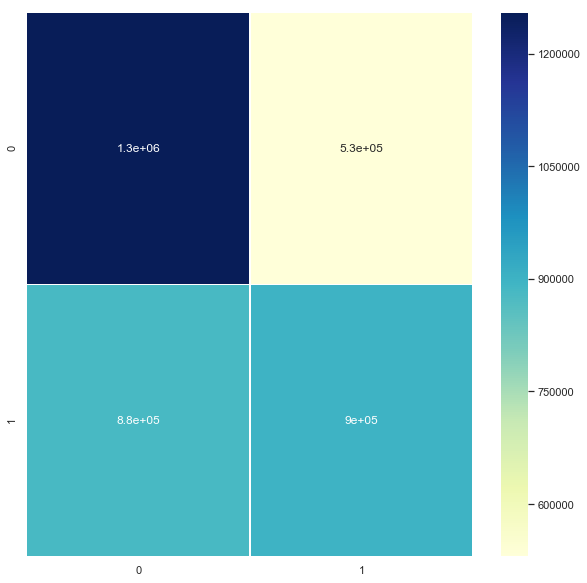

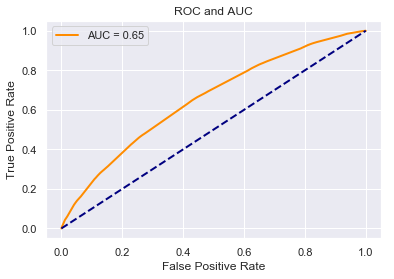

AUC score: 0.651


0.6514413749957542

In [8]:
# n_estimators = 20

save_model =  MODEL_PATH + 'random_forest_model_20.sav'
random_forest_classifier = RandomForestClassifier()

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, random_forest_classifier, save_model)
    
Util.predictModel(train_test_list, save_model)
# ROC, AUC
Util.plotROC(train_test_list, save_model)

In [9]:
# n_estimators = 30

save_model =  MODEL_PATH +'random_forest_model_30.sav'
random_forest_classifier = RandomForestClassifier(n_estimators = 30)

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, random_forest_classifier, save_model)
    
Util.predictModel(train_test_list, save_model)
# ROC, AUC
Util.plotROC(train_test_list, save_model)

MemoryError: 

In [ ]:
# n_estimators = 50

save_model =  MODEL_PATH +'random_forest_model_50.sav'
random_forest_classifier = RandomForestClassifier(n_estimators = 50)

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, random_forest_classifier, save_model)
    
Util.predictModel(train_test_list, save_model)
# ROC, AUC
Util.plotROC(train_test_list, save_model)

## V. Hyperparameter Tuning

Use GridSearchCV here to find the best Logistic Regression model.

### Numeric columns only

In [ ]:
df_pkl = DATA_PATH + "train_clean_numeric.pkl"

if not os.path.exists(df_pkl):
    # re-load from exported csv
    df_train_clean_numeric = pd.read_csv(DATA_PATH + "train_clean_numeric.csv")
    df_train_clean_numeric.to_pickle(df_pkl)

df_train_clean_numeric = pd.read_pickle(df_pkl)

# train test split
train_test_list = Util.trainTestSplit(df_train_clean_numeric,'HasDetections',0.4)

# use StandardScaler
scaler = StandardScaler()
train_test_list = Util.scale(train_test_list,scaler)

In [ ]:
# cross validation to find the hyperparameters
X_train = train_test_list[0]
y_train = train_test_list[2]

Best: 0.587502 using {'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'lbfgs'}
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=7,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# Logistic Regression
time_start = time.time()

max_iter= [100,110,120]
inv_regularization_strength = [10**i for i in np.arange(-1,1,0.5)]
solvers = ['lbfgs']
class_weight = ['balanced']
param_grid = dict(max_iter = max_iter, 
                  C = inv_regularization_strength, 
                  solver = solvers, 
                  class_weight = class_weight)

LR_model = LogisticRegression(random_state = 7)

# instantiate the grid search
grid = GridSearchCV(estimator = LR_model, param_grid = param_grid, cv = 3, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result.best_estimator_)
display("Execution time:{0} sec.".format(time.time() - time_start))

After we found the best model, train and predict it, using ROC Curve and AUC to evaluate it

In [ ]:
# use Logistic Regression
save_model = MODEL_PATH + 'logreg_model_best.sav'
logreg_model = LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=7,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

#if saved model is not found, train the model
if not os.path.exists(save_model):
    Util.trainModel(train_test_list, logreg_model, save_model)
    
Util.predictModel(train_test_list, save_model)
Util.plotROC(train_test_list, save_model)

## Summary

This notebook documents the process of the initial stages of this project. After data preprocessing, a minimun usable dataset contains only numric data is obtained. (Other types of data is preserved for future use.) Logistic Regression and Random Forest Classifer has been applied to make the prediction. However, at this stage, predicted result is not optimal and not reaching desired accuracy. For most models, AUC score falls within 0.58 - 0.65 range and still have high Type I, Type II errors. For future improvements, Feature engineering is in-progress, and more advanced model such as Neural Network will be applied to improve the result.